**02452** *Machine Learning*, Technical University of Denmark

- This Jupyter notebook contains exercises where you fill in missing code related to the lecture topic. *First*, try solving each task yourself. *Then* use the provided solution (an HTML file you can open in any web browser) as inspiration if needed. If you get stuck, ask a TA for help.

- Some tasks may be difficult or time-consuming - using the solution file or TA support is expected and perfectly fine, as long as you stay active and reflect on the solution.

- You are not expected to finish everything during the session. Prepare by looking at the exercises *before* the class, consult the TAs *during* class, and complete the remaining parts *at home*.

---

# Week 7: Performance evaluation and AUC

**Content:** 
- Part 1: Statistical evaluation of a single classifier (Setup I)
- Part 2: Statistical comparison of multiple classifiers (Setup I)
- Part 3: Statistical evaluation of a single regression model (Setup I)
- Part 4: Statistical comparison of multiple regression models (Setup I)
- Part 5: Setup II - Accounting for variability in the training set
- Part 6: ROC Curves and AUC

**Objectives:**
- Understand how to estimate and interpret model performance statistically.
- Explain the difference between **Setup I** and **Setup II** for performance evaluation.
- Compute and interpret **confidence intervals** for model performance estimates.
- Compare models statistically for both **classification** and **regression** tasks.
- Understand the motivation and interpretation of the **ROC curve** and **AUC**.

In [144]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
import scipy.stats as st

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# Random seed
seed = 42
np.random.seed(seed)
random.seed(seed)

def rocplot(p, y, ax=None, color="C0", label=None):
    """
    Plot the Receiver Operating Characteristic (ROC) curve and compute the AUC.

    Args:
        p (array-like): Predicted probabilities for the positive class.
        y (array-like): True binary class labels (0 or 1).
        ax (matplotlib.axes.Axes, optional): Axis to plot on.
        color (str, optional): Line color.
        label (str, optional): Label for the ROC curve.

    Returns:
        float: AUC
    """
    fpr, tpr, _ = metrics.roc_curve(y, p)
    auc_value = metrics.roc_auc_score(y, p)

    if ax is None:
        ax = plt.gca()

    ax.plot(fpr, tpr, color=color, lw=2, label=f"AUC = {auc_value:.3f}")
    ax.plot([0, 1], [0, 1], "k--", lw=1)
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("False Positive Rate (1 - Specificity)")
    ax.set_ylabel("True Positive Rate (Sensitivity)")
    ax.set_title("ROC Curve")
    ax.grid(True, linestyle="--", alpha=0.5)
    if label or auc_value:
        ax.legend(loc="lower right")

    return auc_value

def confmatplot(y_true, y_pred, ax=None, cmap="Blues"):
    """
    Plot a styled confusion matrix.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        ax (matplotlib.axes.Axes, optional): Axis to plot on.
        cmap (str, optional): Colormap for heatmap.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    acc = 100 * cm.diagonal().sum() / cm.sum()
    err = 100 - acc

    if ax is None:
        ax = plt.gca()

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(f"Confusion Matrix\nAccuracy: {acc:.1f}%, Error: {err:.1f}%")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(np.arange(cm.shape[1]))
    ax.set_yticklabels(np.arange(cm.shape[0]))

    # Add counts in cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                f"{cm[i, j]}",
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=10,
            )

    ax.grid(False)


## Introduction

In last week’s lecture and exercises, we explored generalization error, cross-validation, and the problem of overfitting.  
This week, we’ll follow it up, by learning how to evaluate and compare model performance statistically. 

Our goal is to develop objective methods for deciding which model performs best - not just based on a single error estimate, but by also taking into account the uncertainty in those estimates. Relying on a single number can be misleading, especially when models perform similarly.  
By quantifying the uncertainty around our performance estimates, we can make more reliable and statistically sound comparisons.

In this notebook, you will learn how to:

- Estimate the performance of a single model and compute confidence intervals for that estimate.  
- Compare multiple models statistically, with confidence intervals, for both classification and regression tasks.  
- Understand how different evaluation setups — **Setup I** and **Setup II** — influence how we estimate and interpret performance.  
- Evaluate classification models using ROC curves and the Area Under the Curve (AUC).

We will begin with **Setup I**, and then move on to **Setup II**, where the correlation between overlapping training data in cross-validation is explicitly taken into account.




---
## Part 1: Statistical evaluation of a single classifier (Setup I)

In this part of the exercise, we will explore how to **evaluate and compare classification models** using statistical methods.

Specifically, we will address two key questions:

1. How can we **estimate a reasonable confidence interval** $\left[\theta_L, \theta_U\right]$ for the **accuracy of a single classifier**, based on its predictions on a dataset?  
2. How can we **compare two classifiers** by estimating **confidence bounds for the difference in their accuracies**, $\left[\theta = \theta_A - \theta_B\right]$, where $\theta_A$ and $\theta_B$ represent the accuracies of the two classifiers.

To keep things simple and interpretable, we will focus on comparing **two k-nearest neighbor (k-NN)** classifiers using the classic **Iris dataset**.  
Since this dataset contains only $N = 150$ observations, we will use **leave-one-out** cross-validation (LOO) to obtain $n = N$ model predictions for each classifier.

**Task 1.1:**  Load the Iris dataset into $\boldsymbol{X}$ and $\boldsymbol{y}$.
> *Hint:* Remember to make $\boldsymbol{y}$ categorical.

In [145]:
# load iris.csv
path = r'C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\Lecture_7\data\iris.csv'
data = pd.read_csv(path)

X = data.drop(columns = ['Type'])
y = data['Type']
le = LabelEncoder()
y = le.fit_transform(data['Type'])

assert X.shape == (150, 4), "There should be 150 samples and 4 features in the Iris dataset."
assert y.shape == (150,), "There should be 150 labels in the Iris dataset."

First, we will evaluate the **performance of individual models**.
We’ll train three k-nearest neighbor (KNN) classifiers with different values of $k: k=1, k=20, k=80$, we'll refer to these as $\mathcal{M}_A$, $\mathcal{M}_B$ and $\mathcal{M}_C$.

The script below performs leave-one-out cross-validation (LOO) and saves the predictions from each model in a dictionary called `y_preds`.

**Task 1.2:** Initialize Leave-One-Out cross-validation, save it as `CV_loo`.

**Task 1.3:** Split the data into training and test sets for the current fold.  
> *Hint:* Use `.iloc` with the provided `train_index` and `test_index` to extract the correct rows from `X` and `y`.

**Task 1.4:** Fit a KNN model for each value of $k$ within the loop, predict on the test observation, and store the result as `y_pred`.
> *Hint:* Use `KNeighborsClassifier`.

> *Hint:* We will later use our predictions for **model-comparison**, wherein it is extremely important that the predictions are in the same order for all models. Make sure you always predict with each model within the same CV. Rather than have separate CVs for each model.

In [146]:
# Maximum number of neighbors
K_neighbours = [1, 20, 80]

# 1.2) Initialize Leave-One-Out cross-validation - save it as CV_loo
CV_loo = LeaveOneOut()

# store predictions
y_true = []
y_preds = {"Model_A": [], "Model_B": [], "Model_C": []}
model_names = list(y_preds.keys())

# Loop through the folds
for fold, (train_index, test_index) in tqdm(enumerate(CV_loo.split(X)), desc="Crossvalidation fold", total=CV_loo.get_n_splits(X)):
    
    # extract training and test set for current CV fold
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit classifier and classify the test points.
    for model_idx, k in enumerate(K_neighbours):
        # 1.4) Create and fit KNN model with k neighbours. Predict the test set, save as y_pred.
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        

        # Store predictions in dictionary
        y_preds[model_names[model_idx]].append(y_pred)

    y_true.append(y_test)

# Concatenate the list of arrays into a single array
y_true = np.concatenate(y_true)
y_preds = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

Crossvalidation fold:   0%|          | 0/150 [00:00<?, ?it/s]

**Task 1.5:** Compute the accuracy of each of the three models, $\mathcal{M}_A$, $\mathcal{M}_B$ and $\mathcal{M}_C$. Which model performs best?

In [147]:
for model_name, y_pred in y_preds.items():
    acc_score = accuracy_score(y_true, y_pred)
    print(f'Accuracy for {model_name}: {acc_score:.2f}')
    

Accuracy for Model_A: 0.96
Accuracy for Model_B: 0.98
Accuracy for Model_C: 0.88


We will now compute **Jeffreys interval**, i.e. the confidence interval of the three models. 

If $m$ is the number of accurate guesses in $n$ trials, then we can calculate the probability of the classifier being correct: 

$$
p(\theta \mid m, n)=\operatorname{Beta}(\theta \mid a, b),
$$

$$
 a=m+\frac{1}{2}, \text { and } b=n-m+\frac{1}{2}
$$

The $1-\alpha$ confidence interval, $\left[ \theta_L, \theta_U \right]$, is given as:
$$
\theta_L=\operatorname{cdf}_B^{-1}\left(\left.\frac{\alpha}{2} \right\rvert\, a, b\right) \text { if } m>0 \text { otherwise } \theta_L=0,
$$

$$
\theta_U=\operatorname{cdf}_B^{-1}\left(\left.1-\frac{\alpha}{2} \right\rvert\, a, b\right) \text { if } m<n \text { otherwise } \theta_U=1
$$

Such that the probability of $\theta$ being within the confidence interval is $1-\alpha$:
$$
P\left(\theta \in \left[\theta_U, \theta_L \right] \right) = 1 - \alpha
$$

While the mean is cauculated as follows:

$$
\hat{\theta}=\mathbb{E}[\theta]=\frac{a}{a+b}
$$


**Task 1.6:** Fill in the `jeffrey_interval` function below, it should return the point estimate `theta_hat` and confidence interval `CI`.
> *Hint:* Calculate the number of correct predictions `m`. Use that and `n` to calculate `a` and `b`.

> *Hint:* Use the function `st.beta.interval(1 - alpha, a=a, b=b)` to calculate the confidence interval. 

In [148]:
def jeffrey_interval(y_true: np.ndarray, y_preds: np.ndarray, *, alpha: float) -> (float, tuple):
    """
    Calculate the Jeffrey's interval for a binary classification problem.

    Parameters:
    y_true (numpy.ndarray): The true labels of the binary classification problem.
    y_preds (numpy.ndarray): The predicted labels of the binary classification problem.
    alpha (float, optional): The significance level for the confidence interval. Default is 0.05.

    Returns:
    theta_hat (float): The point estimate of the accuracy.
    CI (tuple): The lower and upper bounds of the confidence interval.
    """

    # Total number of predictions
    n = len(y_true)

    m = sum(y_true == y_preds)
    
    a = m + 1/2
    b = n - m + 1/2
     
    return a / (a + b), st.beta.interval(1 - alpha, a=a, b=b)
        

# Compute the Jeffreys interval
alpha = 0.01

print(f'The theta value describes the model s chance that the prediction is correct.')
print(f'We are {(1-alpha)*100} % confident that theta lies in CI')
for model_name in y_preds.keys():
    theta_hat, CI = jeffrey_interval(y_true, y_preds[model_name], alpha=alpha)
    print(f"{model_name}: Theta: Correct prediction chance {theta_hat*100:.4f}% | CI: We are {(1-alpha)*100} confident that theta lies between [{CI[0]:.4f}, {CI[1]:.4f}]")

The theta value describes the model s chance that the prediction is correct.
We are 99.0 % confident that theta lies in CI
Model_A: Theta: Correct prediction chance 95.6954% | CI: We are 99.0 confident that theta lies between [0.9037, 0.9880]
Model_B: Theta: Correct prediction chance 97.6821% | CI: We are 99.0 confident that theta lies between [0.9341, 0.9967]
Model_C: Theta: Correct prediction chance 87.7483% | CI: We are 99.0 confident that theta lies between [0.8001, 0.9363]


**Task 1.7:** Considering the confidence intervals, which is the best performing model now?

- Theta is a chance of a model to make a correct prediction. So model B is the best.

**Task 1.8:** Try to change $\alpha$ to $\alpha = 0.1$ and $\alpha = 0.01$. What effect does this have on the Jeffrey interval? Explain how $\alpha$ influences $P\left(\alpha \in \left[\theta_L, \theta_U \right]\right)$.

- Confidence interval represents a range of values within which we believe the true value of a parameter — in this case, Theta — is likely to fall, with a certain level of confidence.





---
## Part 2: Statistical comparison of multiple classifiers (Setup I)

In the previous part, we evaluated the performance of individual classifiers by estimating their accuracies and their confidence intervals. 
In this part, we will learn how to **compare two classifiers** in a way that accounts for the uncertainty in their predictions.

A common approach for comparing two classification models on the **same dataset** is **McNemar’s test**.  
This test is specifically designed for **paired nominal data**, where both models make predictions on the same test samples. It focuses on how often the models disagree on the classification of each observation.

The intuition behind McNemar’s test is simple:
- We build a **2×2 contingency table** summarizing how often each model was correct or incorrect on the same samples.  
- The test then checks whether the number of samples misclassified by one model but correctly classified by the other differs **more than would be expected by chance**.

This allows us to formally test the null hypothesis - wherein we want to compare the difference between two classifiers, $\theta = \theta_A - \theta_B$:

$$
H_0: \theta = 0
$$
$$
H_1: \theta \neq 0
$$

We start by building the contingency table:

$$
\begin{array}{ll}
n_{11}=\sum_{i=1}^n c_i^A c_i^B & =\{\text { Both classifiers are correct }\} \\
n_{12}=\sum_{k=1}^n c_i^A\left(1-c_i^B\right) & =\{A \text { is correct, } B \text { is wrong }\} \\
n_{21}=\sum_{k=1}^n\left(1-c_i^A\right) c_i^B & =\{A \text { is wrong, } B \text { is correct }\} \\
n_{22}=\sum_{k=1}^n\left(1-c_i^A\right)\left(1-c_i^B\right) & =\{\text { Both classifiers are wrong }\}
\end{array}
$$

wherein $c^A$ and $c^B$ are described as: $c_i= \begin{cases}1 & \text { if } \hat{y}_i=y_i \\ 0 & \text { if otherwise } .\end{cases}$

The distribution of the difference is given as:

$$
\begin{aligned}
p(\theta \mid \boldsymbol{n}) & =\frac{1}{2} \operatorname{Beta}\left(\left.\frac{\theta+1}{2} \right\rvert\, a=f, b=g\right), \\
f & =\frac{E_\theta+1}{2}(Q-1) \quad g=\frac{1-E_\theta}{2}(Q-1),
\end{aligned}
$$

Wherein the point-estimate $E_\theta$ and $Q$ are based on how often the models disagree, $n_{12}$ and $n_{21}$, and the total number of predictions, $n$.

$$
E_\theta=\frac{n_{12}-n_{21}}{n}, \quad Q=\frac{n^2(n+1)\left(E_\theta+1\right)\left(1-E_\theta\right)}{n\left(n_{12}+n_{21}\right)-\left(n_{12}-n_{21}\right)^2}
$$

Finally, we can get the confidence intervals of the difference,

$$
\theta_L=2 \operatorname{cdf}_B^{-1}\left(\left.\frac{\alpha}{2} \right\rvert\, a=f, b=g\right)-1, \quad \theta_U=2 \operatorname{cdf}_B^{-1}\left(\left.1-\frac{\alpha}{2} \right\rvert\, a=f, b=g\right)-1,
$$

and the $p$-value, wherein A is better than B if  $n_{12} > n_{21}$:

$$
p=2 \operatorname{cdf}_{\text {binom }}\left(m=\min \left\{n_{12}, n_{21}\right\} \left\lvert\, \theta=\frac{1}{2}\right., N=n_{12}+n_{21}\right)
$$


We will now use the predictions from Part 1, to do McNemar’s test and evaluate whether the observed difference in performance between $\mathcal{M}_A$ and $\mathcal{M}_B$ is statistically significant.


**Task 2.1:** Construct the contingency table `nn`, in the `mcnemar`-function below. 
The table summarizes how often the two classifiers are correct or incorrect on the same samples.
> *Hint:* Start by creating boolean arrays (`cA` and `cB`), indicating whether each classifier’s prediction matches y_true.

| |B correct|B wrong|
|:-|:-:|:-:|
|A correct|$n_{11}$|$n_{12}$|
|A wrong|$n_{21}$|$n_{22}$|

**Task 2.2:** Compute the estimated difference in accuracy, $E_\theta$ (`E_theta`), and the intermediate statistic `Q`, from the values in the contingency table.

**Task 2.3:** Calculate the parameters `f` and `g` for the corresponding Beta distribution.

In [149]:
def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    """
    Perform McNemar's test to compare the accuracy of two classifiers.

    Parameters:
    - y_true: array-like, true labels
    - yhatA: array-like, predicted labels by classifier A
    - yhatB: array-like, predicted labels by classifier B
    - alpha: float, significance level (default: 0.05)

    Returns:
    - E_theta: float, estimated difference in accuracy between classifiers A and B (theta_hat)
    - CI: tuple, confidence interval of the estimated difference in accuracy
    - p: float, p-value for the two-sided test of whether classifiers A and B have the same accuracy
    """

    # Set up the contingency table
    nn = np.zeros((2, 2), dtype=int)

    # 2.1) Fill in the contingency table
    for yhatA_val, yhatB_val, y_true_val in zip(yhatA, yhatB, y_true):
        modelA_bool = bool(yhatA_val == y_true_val)
        modelB_bool = bool(yhatB_val == y_true_val)
        match (modelA_bool, modelB_bool):
            case (True, True):
                nn[0, 0] += 1
            case (False, True):
                nn[1, 0] += 1
            case (True, False):
                nn[0, 1] += 1
            case (False, False):
                nn[1, 1] += 1

    # get values from the contingency table
    n = len(y_true)
    n12 = nn[0, 1]
    n21 = nn[1, 0]
    

    # 2.2) Calculate E_theta and Q from the values in the contingency table
    E_theta = (n12 - n21) / n

    Q = (
        n**2
        * (n + 1)
        * (E_theta + 1)
        * (1 - E_theta)
        / ((n * (n12 + n21) - (n12 - n21) ** 2))
    )


    # 2.3) Calculate f and g for the beta distribution
    f = (E_theta + 1)/2 * (Q - 1)
    g = (1 - E_theta)/2 * (Q - 1)

    # Calculate confidence interval
    CI = tuple(bound * 2 - 1 for bound in st.beta.interval(1 - alpha, a=f, b=g))

    # Calculate p-value for the two-sided test using exact binomial test
    p = 2 * st.binom.cdf(min([n12, n21]), n=n12 + n21, p=0.5)

    print(f"Result of McNemars test using alpha = {alpha}\n")
    print("Contingency table")
    print(nn, "\n")
    if n12 + n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=", (n12 + n21))

    print(f"Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = {CI[0]:.4f}, {CI[1]:.4f}\n")
    print(
        f"p-value for two-sided test A and B have same accuracy (exact binomial test): p={p}\n"
    )

    return E_theta, CI, p

In [150]:
# Compute the Jeffreys interval
alpha = 0.05
[theta_hat, CI, p] = mcnemar(y_true, y_preds["Model_A"], y_preds["Model_B"], alpha=alpha)

print(f"theta = theta_A-theta_B point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}")


Result of McNemars test using alpha = 0.05

Contingency table
[[143   1]
 [  4   2]] 

Warning, n12+n21 is low: n12+n21= 5
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.0489, 0.0090

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.375

theta = theta_A-theta_B point estimate: -0.02
 CI: [-0.0489, 0.0090]
 p-value: 0.375


You should find $\theta$ being very slightly negative, which is weak evidence towards $\mathcal{M}_B$ having a relatively higher accuracy than $\mathcal{M}_A$. Meanwhile, the p-value is relatively high, indicating the result is likely due to chance. All in all the result is inconclusive and we should not conclude $\mathcal{M}_B$ is better than $\mathcal{M}_A$.

**Task 2.4:** Run the function above again, to compare $\mathcal{M}_A$ against $\mathcal{M}_C$. Based on these results, are there statistically good reasons to believe $\mathcal{M}_A$ is better than $\mathcal{M}_C$?

Yes, A is better than C, as well as, B is better than C. The statistical reason is due to slightly possitive theta and p-value is < 0.002.


**Task 2.5:** Go back to the cross-validation code-block, replace $\mathcal{M}_B$ with a classification tree model. Use McNemar’s test to compare the decision tree against a KNN classifier with k = 1 ($\mathcal{M}_A$). Comment on the result of the evaluation. Is one model better than the other?


---
## Part 3: Statistical evaluation of a single regression model (Setup I)

We will now move on to **evaluate and compare regression models** using statistical methods.

Specifically, we will address two key questions:

1. How can we **estimate a reasonable confidence interval** $\left[z_L, z_U\right]$ for the **performance of a single regression model**, based on its predictions on a dataset?  
2. How can we **compare two regression models** by estimating confidence bounds for the difference in their performances.

Since we do not have many candidate regression models to choose from at this point, we will compare the **linear regression** model against a **regression tree**, where we will predict alcohol content in the **Wine dataset**.

**Task 3.1:**  Load the Wine dataset into $\boldsymbol{X}$ and $\boldsymbol{y}$ (`Alcohol`), don't use `Color` and `Quality score (0-10)`.
> *Hint:* Remember to filter outliers: `df = df[~((df['Volatile acidity'] > 2) | (df['Density'] > 1) | (df['Alcohol'] > 20))]`

In [158]:
path = r'C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\Lecture_7\data\wine.csv'
df = pd.read_csv(path)
df = df[~((df['Volatile acidity'] > 2) | (df['Density'] > 1) | (df['Alcohol'] > 20))]
X = df.drop(columns = ['Alcohol', 'Color', 'Quality score (0-10)'])
y = df['Alcohol']

assert X.shape == (6304, 10), "There should be 6304 samples and 10 features in the Wine dataset."
assert y.shape == (6304,), "There should be 6304 labels in the Wine dataset."

First, we will evaluate the **performance of individual models**.
We’ll train a linear regression model and a decision tree regressor, we'll refer to these as $\mathcal{M}_A$ and $\mathcal{M}_B$.

The script below performs 10-fold cross-validation and saves the predictions from each model in a dictionary called `y_preds`.

**Task 3.2:** Initialize 10-fold cross-validation, save it as `CV_kfold`.

**Task 3.3:** Split the data into training and test sets for the current fold.  
> *Hint:* Use `.iloc` with the provided `train_index` and `test_index` to extract the correct rows from `X` and `y`.

**Task 3.4:** Fit a linear regression model and a decision tree regressor, predict on the test set, and store the result as `y_pred_A` and `y_pred_B`.
> *Hint:* Use `LinearRegression` and `DecisionTreeRegressor` with default parameters.

> *Hint:* We will later use our predictions for **model-comparison**, wherein it is extremely important that the predictions are in the same order for all models. Make sure you always predict with each model within the same CV. Rather than have separate CVs for each model.

In [159]:
# 3.2) Initialize 10-fold cross-validation - save it as CV_kfold
CV_kfold = KFold(n_splits=10)

# store predictions
y_true = []
y_preds = {"Model_A": [], "Model_B": []}
model_names = list(y_preds.keys())

# Loop through the folds
for fold, (train_index, test_index) in tqdm(enumerate(CV_kfold.split(X)), desc="Crossvalidation fold", total=CV_kfold.get_n_splits(X)):
    
    # extract training and test set for current CV fold
    # 3.3) Split the data into training and test sets for the current fold - remember iloc
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 3.4) Create and fit a Linear Regression model (model_A) and a DecisionTreeRegressor (model_B) with default parameters. 
    model_A = LinearRegression()
    model_A.fit(X_train, y_train)
    y_preds_A = model_A.predict(X_test)

    model_B = DecisionTreeRegressor()
    model_B.fit(X_train, y_train)
    y_preds_B = model_B.predict(X_test)

    
    y_preds["Model_A"].append(y_preds_A)
    y_preds["Model_B"].append(y_preds_B)

    # Append the true labels
    y_true.append(y_test)

# Concatenate the list of arrays into a single array
y_true = np.concatenate(y_true)
y_preds = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

Crossvalidation fold:   0%|          | 0/10 [00:00<?, ?it/s]

We will once again compute the confidence intervals of our models. We'll start by computing our estimated error: 
$$
\hat{z}=\frac{1}{n} \sum_{i=1}^n z_i
$$ 

Picking L1 or L2-loss, we have $z_i$ given as:

$$
z_i=\left|\hat{y}_i-y_i\right| \quad \text { or } \quad z_i=\left(\hat{y}_i-y_i\right)^2
$$

Assuming our losses are normally-distributed, $z_i \sim \mathcal{N}\left(z_i \mid \mu=u, \sigma^2\right)$, our lower- and upper-bound are given as a student's t-distribution:

$$
z_L = \operatorname{cdf}_{\mathcal{T}}^{-1}\!\left(\left.\frac{\alpha}{2} \,\right\rvert\, \nu, \hat{z}, \tilde{\sigma}\right) \\
z_U = \operatorname{cdf}_{\mathcal{T}}^{-1}\!\left(\left.1 - \frac{\alpha}{2} \,\right\rvert\, \nu, \hat{z}, \tilde{\sigma}\right)
$$

with degrees of freedom $\nu=n-1$ and standard error of the mean $\tilde{\sigma}=\sqrt{\sum_{i=1}^n \frac{\left(z_i-\hat{z}\right)^2}{n(n-1)}}$.

We will now compute confidence intervals for our model errors based on the chosen loss function (L1 or L2). 
The goal is to quantify the uncertainty in our estimated performance, $\hat{z}$, using the **Student’s t-distribution**.

The function `confidence_interval()` below should compute:
1. The estimated error $\hat{z}$
2. The confidence interval $[Z_L, Z_U]$, assuming normally distributed losses.

**Task 3.5:** Compute the errors, $z$, and the estimated average error, $\hat{z}=\frac{1}{n} \sum_{i=1}^n z_i$, in the function below.
> *Hint:* Apply the chosen loss function (`loss_fn`) to `y_true` and `y_preds` for `z` then take the mean using `np.mean()` to get `z_hat`.

**Task 3.6:** Compute the **standard error of the mean**, using the formula: $\tilde{\sigma}=\sqrt{\sum_{i=1}^n \frac{\left(z_i-\hat{z}\right)^2}{n(n-1)}}$
> *Hint:* You can calculate this directly with NumPy operations.


**Task 3.7:** Compute the **confidence interval** using the Student’s t-distribution.  
> *Hint:* Use `st.t.interval(confidence, df, loc, scale)`, where:`confidence = 1 - alpha`, `df = n - 1`, `loc = z_hat` and `scale = sem`.


In [160]:
# Defining our loss functions
l1_loss = lambda y, y_pred: np.abs(y - y_pred)
l2_loss = lambda y, y_pred: (y - y_pred)**2


def confidence_interval(y_true, y_preds, loss_fn, alpha=0.05):

    # 3.5) Calculate estimated error, z_hat, as the mean loss across all samples
    z = loss_fn(y_true, y_preds)

    z_hat = np.mean(z)
    
    # n and nu
    n = len(y_true)
    nu = n - 1  # degrees of freedom

    # 3.6) Calculate standard error of the mean of the losses (sem)
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu)))
    
    # 3.7) Calculate the confidence interval
    CI = st.t.interval(1 - alpha, nu, z_hat, sem)

    return z_hat, CI

# Compute the confidence interval
alpha = 0.05

for model_name in y_preds.keys():
    z_hat, CI = confidence_interval(y_true, y_preds[model_name], l2_loss, alpha=alpha)
    print(f"{model_name}: z_hat: {z_hat:.4f}, CI: [{CI[0]:.4f}, {CI[1]:.4f}]")

Model_A: z_hat: 0.2641, CI: [0.2514, 0.2768]
Model_B: z_hat: 0.4656, CI: [0.4415, 0.4898]


**Task 3.8** Considering the confidence intervals, which is the best performing model?

Model_B is the best performing model. Its point estimate is substantially higher, and its confidence interval does not overlap with Model_A’s interval, so the difference is statistically meaningful at the reported confidence level.

We are 95% confident that model B chance of guessing the correct value is in the range 44% - 49%.


---
## Part 4: Statistical comparison of multiple regression models (Setup I)

In the previous part, we evaluated the performance of individual regression models by estimating their performance and their confidence intervals. 
In this part, we will learn how to **compare two classifiers** in a way that accounts for the uncertainty in their predictions.

We now let $\hat{z}$ be the difference in loss between the two models, $\hat{z}=\frac{1}{n} \sum_{i=1}^n z_i$, where $z_i=z_i^A-z_i^B$.

We once again assume $z_i$ to be normally distributed,  $z_i \sim \mathcal{N}\left(z_i \mid \mu=u, \sigma^2\right)$ - which essentially means that $\hat{Z}$ and the confidence intervals can be computed through the exact same formulas as before. 

Finally, our hypotheses become:

$H_0:$ Model $\mathcal{M}_A$ and $\mathcal{M}_B$ have the same performance, $u=0$

$H_1:$ Model $\mathcal{M}_A$ and $\mathcal{M}_B$ have different performance, $u \neq 0$

Wherein the $p$-value is given from the students t-distribution: 
$$p=2 \operatorname{cdf}_{\mathcal{T}}(-|\hat{z}| \mid \nu=n-1, \mu=0, \sigma=\tilde{\sigma})$$

**Task 4.1:** Compute the difference in errors, $z$, and the estimated average difference in errors error, $\hat{z}=\frac{1}{n} \sum_{i=1}^n z_i$, where $z_i=z_i^A-z_i^B$, in the function below.
> *Hint:* Apply the chosen loss function (`loss_fn`) to `y_true` and `y_preds` for each model, and subtract them to get `z`, then take the mean using `np.mean()` to get `z_hat`.

**Task 4.2:** Insert the solution from **Task 3.6** to calculate $\tilde{\sigma}=\sqrt{\sum_{i=1}^n \frac{\left(z_i-\hat{z}\right)^2}{n(n-1)}}$.

**Task 4.3:** Insert the solution from **Task 3.7** to calculate the confidence interval. 

**Task 4.4:** Calculate the p-value.
> *Hint:* You can use `2 * st.t.cdf(t_stat, df=nu)`, wherein `t_stat` is given as: $t = \frac{\hat{z} - \mu_0}{\tilde{\sigma}}$, in the null-hypothesis our hypothesized mean, $\mu_0 = 0$.

In [162]:
def confidence_interval_comparison(y_true, y_preds_A, y_preds_B, loss_fn, alpha=0.05):

    # 4.1) Calculate estimated error, z_hat, as the mean loss across all samples
    z = loss_fn(y_true, y_preds_A) - loss_fn(y_true, y_preds_B)
    z_hat = np.mean(z)
    
    # n and nu
    n = len(y_true)
    nu = n - 1  # degrees of freedom

    # 4.2) Insert solution from task 3.6 here
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu)))
    
    # 4.3) Insert solution from task 3.7 here
    CI = st.t.interval(1 - alpha, nu, z_hat, sem)

    # 4.4) Calculate the p-value for the two-sided test using the t-distribution
    t_stat = -np.abs(np.mean(z)) / st.sem(z)
    p_value = 2 * st.t.cdf(t_stat, df=nu)

    return z_hat, CI, p_value

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds["Model_A"], y_preds["Model_B"], l2_loss, alpha=alpha)
print(f"Difference in loss between Model_A and Model_B: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

Difference in loss between Model_A and Model_B: 
z_hat: -0.2015, 
CI: [-0.2248, -0.1782], 
p-value: 4.726147750832069e-63


**Task 4.4:** What is the confidence interval and p-value, and what would you conclude based on these results?

**Task 4.5:** Try leave-one-out cross-validation instead, what happens?


---
## Part 5: Setup II - Accounting for variability in the training set

So far, in **Setup I**, we have only considered performance evaluation under the assumption that our model is **trained on a fixed training set**.  
In that setup, all statistical estimates — such as generalization error, confidence intervals, and model comparisons — describe the behavior of a model trained on that *specific dataset*.  

However, even if we could perfectly evaluate that model’s performance (for example, with an infinite test set), we would still miss an important source of variability:  
> What happens if we train the same model on a *different* training set drawn from the same population?

In **Setup II**, we no longer treat the training data as fixed.  
Instead, we consider the generalization error averaged over *all possible training sets of size N*:

$$
E_{\text{gen}} = 
\int\!\!\int L(f_{D_{\text{train}}}(x), y)\,dx\,dy\,dD_{\text{train}}
$$

This means we are now interested in the **expected performance of the learning algorithm itself**, not just a single trained model.

In practice, we approximate this by training our model on several (ideally independent) training/test splits:
$$
(D_{\text{train}}^{(1)}, D_{\text{test}}^{(1)}), \ldots, (D_{\text{train}}^{(J)}, D_{\text{test}}^{(J)}),
$$
computing one generalization error estimate for each of these $J$ splits:
$$
r_j = \frac{1}{n_j} \sum_{i=1}^{n_j} L(f_{D_{\text{train}}^{(j)}}(x_i^{(j)}), y_i^{(j)}),
$$
and then taking their average:
$$
\hat{r} = \frac{1}{J} \sum_{j=1}^J r_j.
$$

In practice, we often obtain these $J$ splits using **cross-validation**, exactly like we've been doing in all of the previous exercises today. But this is what creates the problem, 
as the training sets $D_{\text{train}}^{(j)}$ in cross-validation **overlap heavily**, so the resulting models (and their error estimates $r_j$) are not independent.

As the training data across datasets appear in multiple cross-validation splits, it is no surprise that they are correlated by some $\Sigma$:

$$
r_j = \bar{z} + v_j, \quad v \sim \mathcal{N}(0, \Sigma),
$$


The covariance matrix can be described through its diagonal and off-diagonal elements - where, $\sigma^2$ represents the **true variance** in test errors due to noise in data, and $\rho$ represents the (unknown) **correlation** between estimates caused by overlapping training sets.

$$
\Sigma_{ii} = \sigma^2, \quad \Sigma_{ij} = \rho \sigma^2.
$$

Since it is not possible to estimate both $\sigma^2$ and $\rho$ directly from one dataset (Bengio & Grandvalet, 2004), we use a **correlation heuristic** proposed by Nadeau & Bengio (2000):

$$
\rho = \frac{|D_{\text{test}}|}{|D_{\text{train}}| + |D_{\text{test}}|} = \frac{1}{K}
$$

for $K$-fold cross-validation.  

This heuristic accounts for the dependency between training sets while keeping the analysis tractable.  
Under this model, the variance of our estimated mean performance becomes:

$$
\tilde{\sigma}^2 =
\left( \frac{1}{J} + \frac{1}{K - 1} \right)
\hat{s}^2,
$$
where
$$
\hat{s}^2 = \frac{1}{J - 1} \sum_{j=1}^{J} (r_j - \bar{r})^2
$$
is the observed variance across the $J$ repeated cross-validation estimates.

**In practice**, though it might sound complicated, this is in fact quite simple to estimate. As the training sets within our cross-validation folds are all overlapping, we choose to repeat the cross-validation with different seeds, such that we don't run just $K$ folds - but instead run our cross-validation $m$ independent times, for a total of $J = mK$ folds. 

We then compute our statistical measures through a correlated t-test.


**Task 5.1:** Look at the correlated ttest function below, and make sure you understand it. 

In [163]:
def correlated_ttest(r, rho, alpha=0.05):
    """
    Perform a correlated t-test to compare two models under Setup II.

    Parameters:
    - r (array-like): Array of performance differences across folds (e.g. r_j = error_A - error_B)
    - rho (float): Correlation coefficient between folds (typically 1/K for K-fold CV)
    - alpha (float, optional): Significance level (default: 0.05)

    Returns:
    - p (float): p-value of the test
    - CI (tuple): Confidence interval for the mean difference
    """

    r = np.array(r)
    r_hat = np.mean(r)
    s_hat = np.std(r, ddof=1)
    J = len(r)

    # Adjusted standard deviation accounting for correlation
    sigma_tilde = s_hat * np.sqrt((1 / J) + (rho / (1 - rho)))

    # Confidence interval
    CI = st.t.interval(1 - alpha, df=J - 1, loc=r_hat, scale=sigma_tilde)

    # Two-sided p-value
    p = 2 * st.t.cdf(-np.abs(r_hat) / sigma_tilde, df=J - 1)

    return r_hat, CI, p

**Task 5.2:** Initialize 10-fold cross-validation within the repetition loop.
> *Hint:* Make sure you set a different seed for each repetition!

**Task 5.3:** Compute the mean difference in loss between models, $r_j$, for each fold.

In [165]:
m = 3 # Repetitions
K = 10 # Folds
rho = 1 / K # Correlation heuristic
loss_func = l2_loss # Loss function

r = []

for repeat_idx in range(m):
    print(f"Repetition {repeat_idx+1}/{m}")

    # 5.2) Initialize KFold cross-validation, set the seed to repeat_idx
    ### BEGIN SOLUTION
    CV_kfold = KFold(n_splits=K, shuffle=True, random_state=repeat_idx)
    ### END SOLUTION

    for fold, (train_index, test_index) in tqdm(enumerate(CV_kfold.split(X)), total=CV_kfold.get_n_splits(X),desc="Cross-validation fold"):
        # Split data into training and test sets
        X_train = X.iloc[train_index, :]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index, :]
        y_test = y.iloc[test_index]

        # Fit models: Linear Regression and Decision Tree Regressor
        model_A = LinearRegression().fit(X_train, y_train)
        model_B = DecisionTreeRegressor(random_state=repeat_idx).fit(X_train, y_train)

        # Predict test data
        ypred_A = model_A.predict(X_test)
        ypred_B = model_B.predict(X_test)

        # 5.3) Compute mean difference in loss between models for this fold, r_j
        ### BEGIN SOLUTION 
        r_j = np.mean(loss_func(y_test, ypred_A) - loss_func(ypred_B, y_test))
        ### END SOLUTION

        r.append(r_j)

# Calculate p-value and confidence interval using correlated t-test
r_hat, CI, p_value = correlated_ttest(r, rho, alpha=alpha)

print(f"\nSetup II results:")
print(f"r_hat: {r_hat:.4f}")
print(f"95% CI: [{CI[0]:.4f}, {CI[1]:.4f}]")
print(f"p-value: {p_value}")

Repetition 1/3


Cross-validation fold:   0%|          | 0/10 [00:00<?, ?it/s]

Repetition 2/3


Cross-validation fold:   0%|          | 0/10 [00:00<?, ?it/s]

Repetition 3/3


Cross-validation fold:   0%|          | 0/10 [00:00<?, ?it/s]


Setup II results:
r_hat: -0.0480
95% CI: [-0.0740, -0.0220]
p-value: 0.0007204732516506887


**Task 5.4:** What is the confidence interval and p-value, and what would you conclude based on these results?


---
## Part 6: ROC Curves and AUC

So far, we have evaluated classification performance using metrics such as accuracy, loss, and confidence intervals - all based on discrete class predictions.  
However, many classifiers (such as **logistic regression** or **neural networks**) output a **continuous score** or **probability**, which we later convert into class labels using a threshold (e.g., 0.5).  

By varying this threshold, we can observe how the tradeoff between correctly identifying positive examples and incorrectly labeling negatives changes.  
This relationship is summarized in the **Receiver Operating Characteristic (ROC)** curve.

The **ROC curve** is a graphical tool for evaluating the performance of **binary classifiers**.  

It plots:

- The **True Positive Rate (TPR)** = Sensitivity = Recall  
$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

against

- The **False Positive Rate (FPR)** = 1 − Specificity  
$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

based on TP, FP, TN, FN:
- **True Positives (TP):** Positive samples correctly predicted as positive  
- **False Positives (FP):** Negative samples incorrectly predicted as positive  
- **True Negatives (TN):** Negative samples correctly predicted as negative  
- **False Negatives (FN):** Positive samples incorrectly predicted as negative 

for all possible classification thresholds.

Each point on the ROC curve corresponds to a different threshold value, showing the tradeoff between catching positives and avoiding false positives.

To summarize the ROC curve in a single number, we often use the **Area Under the Curve (AUC)**.  
- A model with **AUC = 0.5** performs no better than random guessing.  
- A model with **AUC = 1.0** achieves perfect classification.  

A higher AUC indicates that the model is better at ranking positive samples higher than negative ones, regardless of the threshold.

In this exercise, we will:
1. Load the **Wine2 dataset** (red vs. white wines) - Wine2 is just Wine1 with removed outliers.  
2. Train a **logistic regression** classifier using **stratified 50/50 train-test splits** to ensure balanced class proportions.  
3. Plot the ROC curve and compute the corresponding AUC score.

We will treat the **red wines as the positive class** and the **white wines as the negative class**.


**Task 6.1:** Load the Wine dataset into $\boldsymbol{X}$ and $\boldsymbol{y}$ (`Color`).
> *Hint:* Make `y` categorical, then access binary labels through `.codes`. 


In [184]:
# 6.1) load data/wine2.csv, split into X and y (Color)
path = r'C:\Users\mrusn\PycharmProjects\02452_Machine_Learning\Lecture_7\data\wine2.csv'
df = pd.read_csv(path)

X = df.drop(columns=['Color'])
y = pd.Categorical(df["Color"]).codes

**Task 6.2:** Initialize stratified K-fold cross-validation with $K=2$, save it as `CV_kfold`.
> *Hint:* Use `StratifiedKFold`, remember to shuffle. 

**Task 6.3:** Create and fit a LogisticRegression model with default parameters. Predict on the test set, save as `y_pred` and predicted probabilities as `p`.
> *Hint:* You have previously used logistic regression on this dataset in Week 5.  
> *Hint:* You can get the probabilities through `model.predict_proba(X_test)[:,1]`.

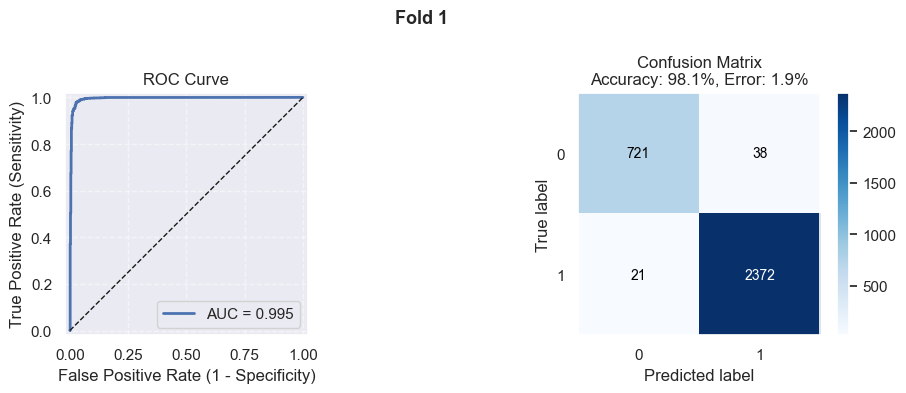

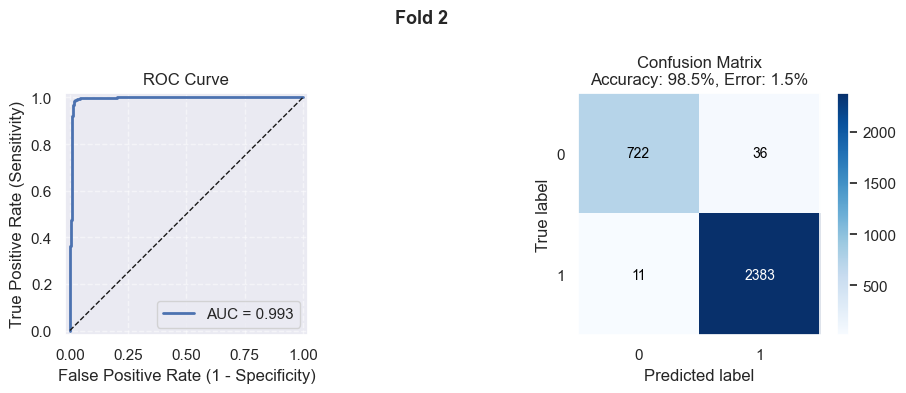

In [185]:
# 6.2) Initialize StratifiedKFold cross-validation with 2 folds - save it as CV_kfold
k = 2
CV_kfold = StratifiedKFold(n_splits = k, shuffle = True)

for fold, (train_index, test_index) in enumerate(CV_kfold.split(X,y)):
    # extract training and test set for current CV fold
    X_train, y_train = X.iloc[train_index,:], y[train_index]
    X_test, y_test = X.iloc[test_index,:], y[test_index]

    # 6.3) Create and fit a LogisticRegression model with default parameters. 
    # Predict on the test set, save as y_pred and predicted probabilities as p.
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    p = model.predict_proba(X_test)[:,1]
    

    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # ROC curve
    rocplot(p, y_test, ax=axes[0])

    # Confusion matrix
    confmatplot(y_test, y_pred, ax=axes[1])

    fig.suptitle(f"Fold {fold+1}", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()


**Task 6.4:** The ROC curve lies very close to the top-left corner. What does this shape tell you about the tradeoff between true positives and false positives for your classifier?

classifier achieves very high true positive rates while keeping false positive rates very low

In the previous task, you used all available features to classify wines as red or white and observed an almost perfect ROC curve with an AUC close to 1.  
In this task, we repeat the experiment - but this time, we will train the classifier using only a single attribute: “Alcohol.”

This will allow us to examine how much information this single feature carries about the wine type, and how this is reflected in the **ROC curve** and the **AUC** score.

**Task 6.5:**  
Restrict your training and test data to include only the **“Alcohol”** attribute - and run the above code again. 
> *Hint:* You can select the column directly using `X["Alcohol"]` or similar indexing - you might have to use `.to_frame()` afterwards, to make the array 2-dimensional.

**Task 6.6:** How can you tell from the ROC curve and the AUC that alcohol content alone is not very useful for distinguishing between red and white wines? Does a single feature provide enough information for reliable classification?

**Task 6.7:** When using logistic regression, do you think it is always best to include **as many attributes as possible**?  
> *Hint:* Consider the potential trade-offs, such as overfitting, correlated features, and model interpretability.
